#**Author:** Mehmet ATAŞ
#**Mail:** mehmet.atas@koctas.com.tr

# Kütüphaneleri Ekleme

In [ ]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import pandas as pd
import tqdm
import seaborn as sns
import random

from sklearn.metrics import confusion_matrix
from PIL import Image
from google.colab import drive

# Verileri Hazırlama

Öncelikle modelimizi eğitmek için kullanacağımız yaklaşık 130000 adet kadın-erkek-çocuk-çalışan-güvenlik resimleri içeren veri setimizi roboflow'da oluşturduğumuz proje üzerinden bizlere sağlanan API aracılığıyla çekiyoruz.

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="68Dt87s4o0pXo5wvYDSU")
project = rf.workspace("amirabbas-kiani").project("demo_classification")
version = project.version(6)
dataset = version.download("folder")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 10.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.7
    Uninstalling idna-3.7:
      Successfully uninstalled idna-3.7
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cycler-0.12.1:
      Successfully uninstalled cycler-

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Demo_Classification-6 in folder::  29%|██▊       | 39374/137143 [00:05<00:12, 7761.15it/s]


KeyboardInterrupt: 

Google drive bağlantısını sağlıyoruz.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

Şimdi görüntülerimizi kayan değerlere rescale(yeniden ölçeklendirmek, değerleri 0 ile 1 arasında olacak şekilde 255'e bölüyoruz) etmek için ImageDataGenerator kullanıyoruz. Ardından verileri eğitim ve doğrulama veri kümelerine ayırmak için her ikisi için flow_from_directory() öğesini çağıyoruz. Her yinelemede bu üreteçler, görüntüleri drivedan okuyarak uygun tensör boyutuna (224 x 224) işleyerek bir dizi görüntü sağlar. Çıktı bir kümedir (resimler, etiketler).

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 64 # her seferde 64 tane resim

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

train_generator = datagen.flow_from_directory(
     "/content/Demo_Classification-6/train",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE)

val_generator = datagen.flow_from_directory(
     "/content/Demo_Classification-6/valid",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
     shuffle=False)


Found 92416 images belonging to 5 classes.
Found 30806 images belonging to 5 classes.


Örnek olarak şekilleri burda görebilirsiniz:

In [ ]:
image_batch, label_batch = next(val_generator)
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 5))

Şimdi ise modelimizi test etmek için kullanacağımız verileri scale etmek ve çeşitlendirmek için ImageDataGenerator yapısını kullanıyoruz.

In [ ]:
ts_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
    )
test_generator = ts_datagen.flow_from_directory(
     "/content/Demo_Classification-6/test",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
     )

Found 13902 images belonging to 5 classes.


Sınıf etiketlerini bir metin dosyasına kaydediyoruz:

In [ ]:
print (train_generator.class_indices)
labels = '\n'.join(sorted(train_generator.class_indices.keys()))
with open('classes.txt', 'w') as f:
  f.write(labels)

{'employee': 0, 'kid': 1, 'man': 2, 'staff': 3, 'woman': 4}


Verisetimizde bulunan sınıf sayısını num_class değişkeninde saklıyoruz. Bu değeri ağımızın çıkış katmanımızda kullanacağız.

In [ ]:
num_classes = len(train_generator.class_indices)

5


In [ ]:
class_names = list(train_generator.class_indices.keys())

In [ ]:
!cat classes.txt

employee
kid
man
staff
woman

# Modelimizi Oluşturma

### Temel Modelimizi ve Sınıflandırma Katmanlarını Oluşturuyoruz

Şimdi, öğrenmeyi yalnızca son bağlı katmana aktarabilen bir model oluşturacağız.

Temel model olarak ImageNet veri kümesiyle önceden eğitilmiş(1.000 sınıfı tanımak üzere) MobileNetV2 ile başlayacağız. Bu bize görüntü sınıflandırması için harika bir özellik çıkarıcı sağlar ve daha sonra verilerimizle yeni bir sınıflandırma katmanı eğitebiliriz.

In [ ]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')


Bu adımda ise önceden eğitilmiş modelden daha fazla katman eğiteceğiz. Tüm katmanları değil fakat dondurulmuş bazı ağırlıkları kendi veri kümemizle tekrardan eğiteceğiz.

In [ ]:
base_model.trainable = True
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Şimdi bir Sequential(sıralı) model oluşturuyoruz ve MobileNetv2 modelini, oluşturacağımız yeni modelin temeli olarak aktarıyoruz ve yeni sınıflandırma katmanları ekliyoruz. Bu şekilde çıkış katmanını veri kümemizdeki sınıf sayısına (5, erkek-kadın-çocuk-çalışan-güvenlik) uyacak şekilde ayarlayabiliriz.

In [ ]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(filters=32, kernel_size=3),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(units=1024, activation='relu'),
  tf.keras.layers.Dense(units=1024, activation='relu'),
  tf.keras.layers.Dense(units=512, activation='relu'),
  tf.keras.layers.Dense(units=256, activation='relu'),
  tf.keras.layers.Dense(units=num_classes, activation='softmax')
])

Şimdi modelimizi derleyeceğiz fakat daha düşük bir öğrenme oranı belirliyoruz.
(default learningrate->(1e-3))

In [ ]:
lr = 1e-5
model.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Aşağıda modelimizin özetini ve eğitilebilir katman sayısını görebilirsiniz.

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 conv2d_4 (Conv2D)           (None, 5, 5, 32)          368672    
                                                                 
 batch_normalization_4 (Bat  (None, 5, 5, 32)          128       
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 5, 5, 32)          0         
                                                                 
 dropout_4 (Dropout)         (None, 5, 5, 32)          0         
                                                                 
 global_average_pooling2d_4  (None, 32)               

In [ ]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Number of trainable weights = 68


Bu adımda eğitilebilir tüm katmanları tekrardan eğiteceğiz.

In [ ]:
!pip install -q pyyaml h5py

# Eğitimin kesilmesi durumuna karşı modelin ağırlıklarını belirli adımlarda kaydediyoruz.
filepath = '/content/drive/MyDrive/checkpoint/weights.h5'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath= filepath,
                                                         monitor='val_accuracy',
                                                         mode='max',
                                                         save_weights_only=True,
                                                         save_best_only=True)
history_fine = model.fit(train_generator,
                         epochs=30,
                         validation_data=val_generator,
                         callbacks=[checkpoint_callback],
                         class_weight={0:1.835, 1:2.149, 2: 0.682, 3: 0.799, 4: 0.785})

Epoch 1/30
1444/1444 [==============================] - 343s 229ms/step - loss: 0.2231 - accuracy: 0.9117 - val_loss: 0.1447 - val_accuracy: 0.9501
Epoch 2/30
1444/1444 [==============================] - 315s 218ms/step - loss: 0.0823 - accuracy: 0.9671 - val_loss: 0.1692 - val_accuracy: 0.9446
Epoch 3/30
1444/1444 [==============================] - 315s 218ms/step - loss: 0.0507 - accuracy: 0.9793 - val_loss: 0.1466 - val_accuracy: 0.9527
Epoch 4/30
1444/1444 [==============================] - 286s 198ms/step - loss: 0.0376 - accuracy: 0.9852 - val_loss: 0.1812 - val_accuracy: 0.9497
Epoch 5/30
1444/1444 [==============================] - 324s 224ms/step - loss: 0.0276 - accuracy: 0.9886 - val_loss: 0.2344 - val_accuracy: 0.9331
Epoch 6/30
1444/1444 [==============================] - 294s 204ms/step - loss: 0.0246 - accuracy: 0.9906 - val_loss: 0.1596 - val_accuracy: 0.9590
Epoch 7/30
1444/1444 [==============================] - 310s 215ms/step - loss: 0.0198 - accuracy: 0.9922 - val_

Bu adımda ise eğittiğimiz modelimizi .keras formatında kaydediyoruz.

In [ ]:
model.save("model.keras")

Modelimizi eğittikten sonra daha önceden hiç görmediği test verilerine karşı nasıl sonuçlar vereceğini görmek adına bu adımda test verileri kullanılarak modelimize tekradan tahminler yaptıracağız. Ardından elde ettiğimiz sonuçlarla Confusion Matrix'i oluşturup sonuçları değerlendireceğiz.

In [ ]:
loss, accuracy = model.evaluate(test_generator, verbose=0)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss, accuracy * 100))

[INFO] loss=0.1386, accuracy: 97.0148%


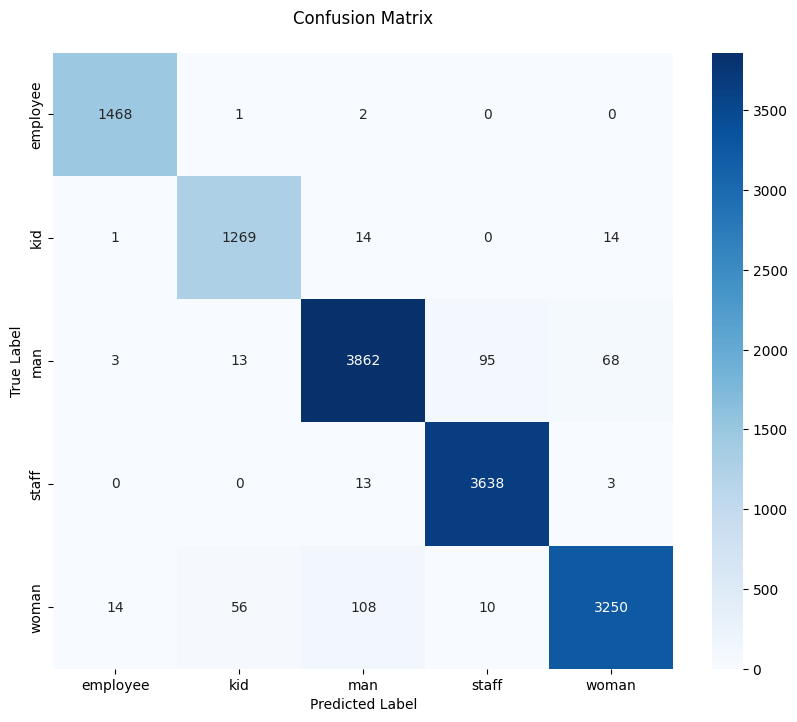

In [ ]:
y_pr = model.predict(test_generator, verbose=0)
y_true = test_generator.labels
y_pred = []
y_pred=np.argmax(y_pr,axis=1)

cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
plt.figure(figsize=(10,8))
class_names = list(train_generator.class_indices.keys())
sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names, fmt='.5g', cmap='Blues')

plt.title('Confusion Matrix\n');
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

Aşağıda ise modelin hatalı tahminler yaptığı verileri görselleştiriyoruz.

In [ ]:
mis_predicted = []
for i in range((len(y_true))):
  if y_pred[i] != y_true[i]:
    mis_predicted.append(i)

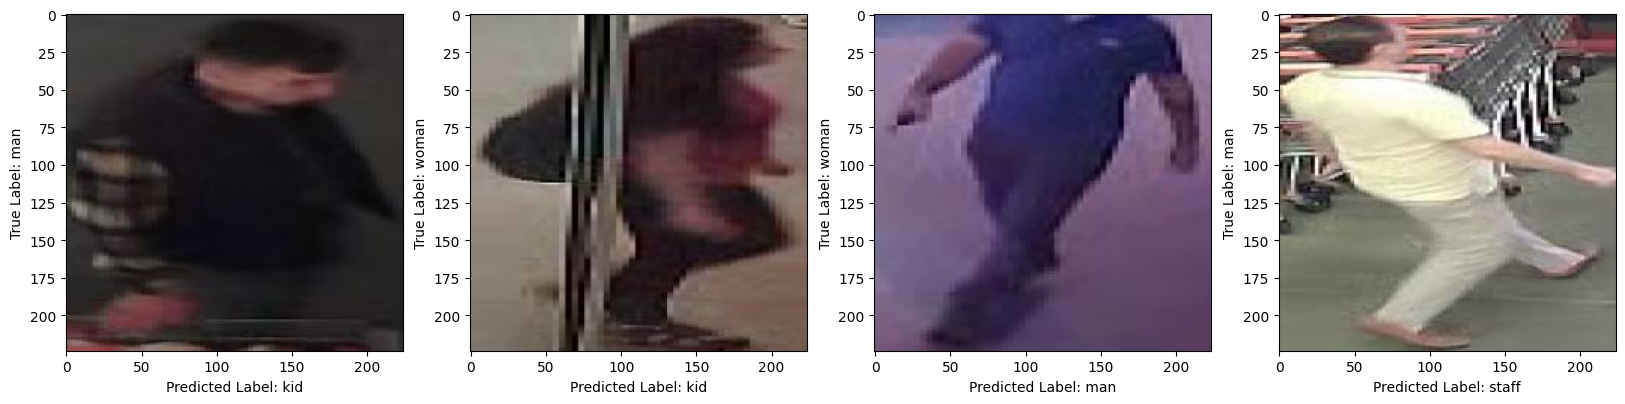

In [ ]:
mis_predicted = []
for i in range((len(y_true))):
  if y_pred[i] != y_true[i]:
    mis_predicted.append(i)

def mispredicted():
  plt.figure(figsize=(20,20))
  for number in range(4):
    index=random.randint(0, (len(mis_predicted)))
    generator_index=int(mis_predicted[index]/BATCH_SIZE)
    test_generator.reset()
    images, labels = next(test_generator)
    for i in range(generator_index):
      images, labels = next(test_generator)
    img = images[mis_predicted[index]%64]
    pil_img = tf.keras.utils.array_to_img(img)
    plt.subplot(1, 4, (number+1))
    plt.imshow(img)
    plt.ylabel(f'True Label: {class_names[y_true[mis_predicted[index]]]}')
    plt.xlabel(f'Predicted Label: {class_names[y_pred[mis_predicted[index]]]}')
  plt.show()
mispredicted()

### Yeni Öğrenme Eğrilerini İnceleyebiliriz:

Yeni öğrenme eğrilerini görselleştiriyoruz:

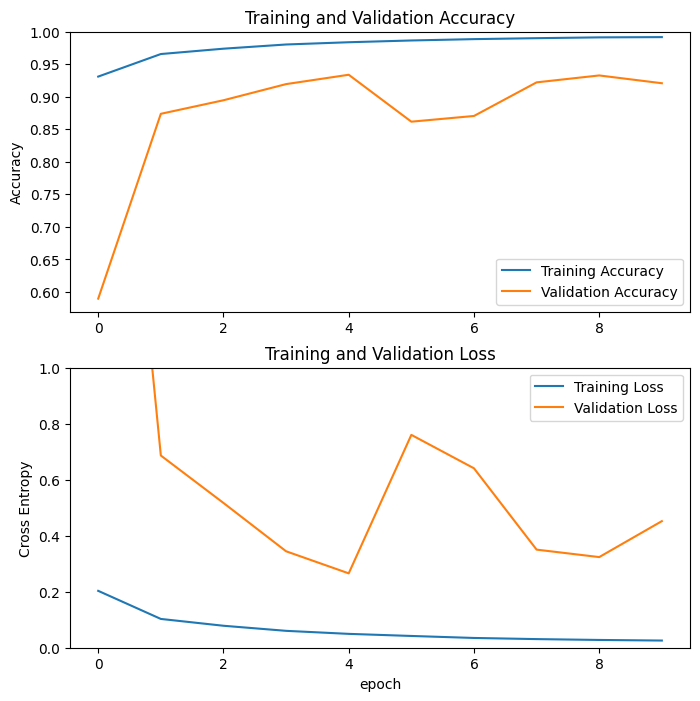

In [ ]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


Modelimiz iyi fakat ideal değil.
Doğrulama kaybı hala eğitim kaybından daha yüksek. Bu nedenle eğitim sırasında eğitim verilerine karşı aşırı uyum olmuş olabilir(overfitting).
Dolayısıyla bu model üretime hazır bir doğrulukta değildir ancak elimizde bulunan verilere karşı yeterince iyi çalışır.

# Modelimizi TFLite'a Çevirme

Normalde bir TFLite modeli oluşturmak TFLiteConverter ile yalnızcabirkaç satırdır. Bu kod temel(un-quantized) bir TFLite modeli oluşturur:

In [ ]:
"""saved_keras_model = 'model.h5'
model.save(saved_keras_model)"""

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('mobilenet_v2_1.0_224.tflite', 'wb') as f:
  f.write(tflite_model)

# Modeli İndirme

In [ ]:
from google.colab import files

files.download('mobilenet_v2_1.0_224_quant_edgetpu.tflite')
files.download('classes.txt')